In [1]:
pip install node2vec



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-geometric



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
#modeling jo
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community as nx_community
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV, learning_curve, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split

In [7]:
from sklearn.preprocessing import StandardScaler

# 2. Charger les données
test_set_final = pd.read_csv("../data/test_set_final.csv", sep=",")
train_set_final = pd.read_csv("../data/train_set_final.csv", sep=",")
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)




In [184]:
selected_columns = ['degree_source', 'centrality_source', 'degree_target', 'centrality_target', 'community_source', 'community_target',\
                     'jaccard', 'salton', 'sorenson', 'hub_promoted', 'hub_depressed', 'leicht_holme_newman', 'adamic_adar', \
                        'resource_allocation', 'common_neighbors', 'shortest_path_length', 'eigenvector_centrality_source',\
                                'eigenvector_centrality_target', 'cosine_similarity']

X_train = train_set_final[selected_columns]
y_train = train_set_final['label']



In [185]:
x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


# BASELINE Random Forest

In [188]:
rf = RandomForestClassifier(random_state= 42)
rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")



Training Accuracy Random Forest: 1.0
Validation Accuracy Random Forest: 0.7047619047619048


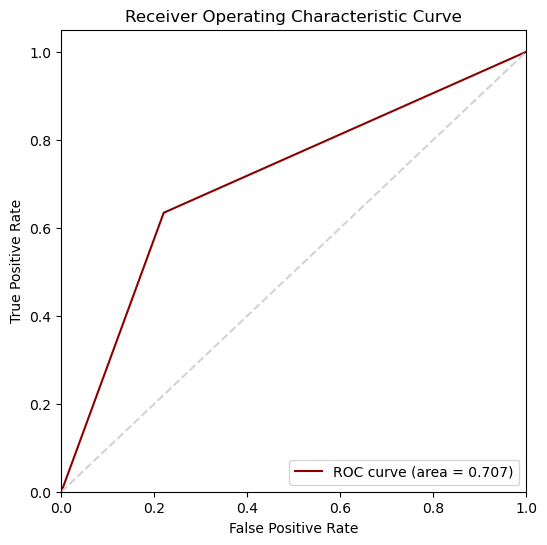

In [189]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(test_labels, test_preds, plot_roc=True):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc, accuracy_score(y_val, y_pred)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_val, y_pred)


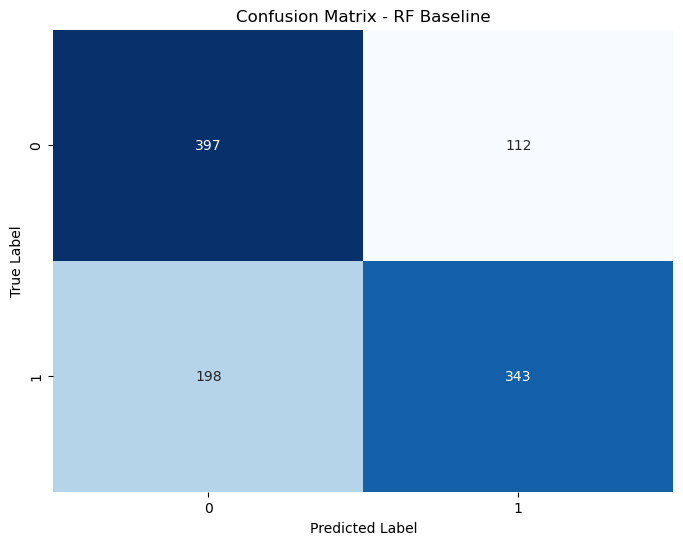

In [31]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - RF Baseline")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

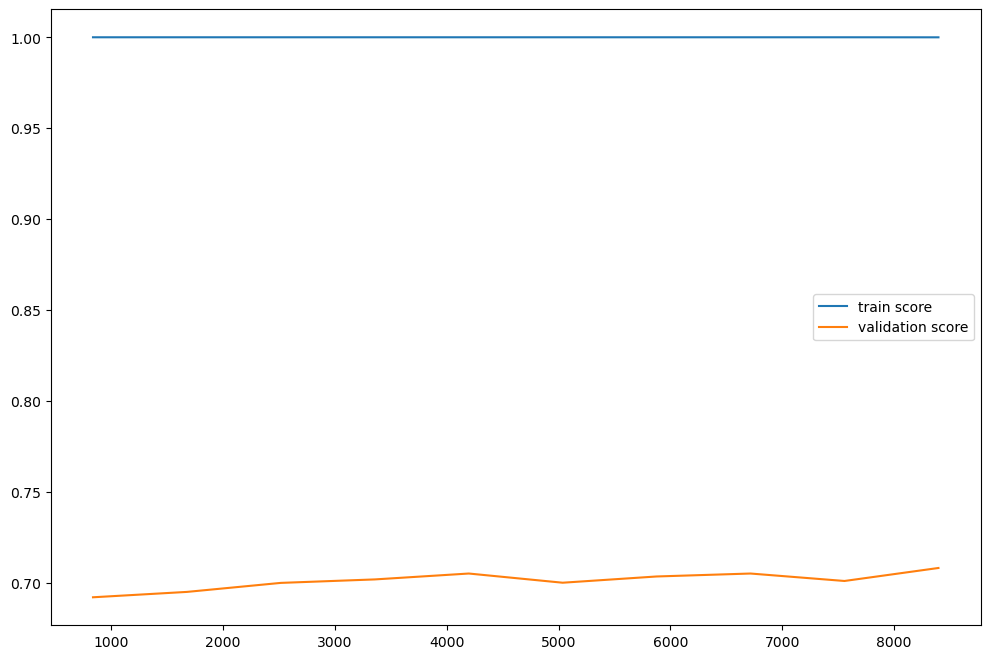

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

def evaluation(model):

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=kfold, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

evaluation(rf)

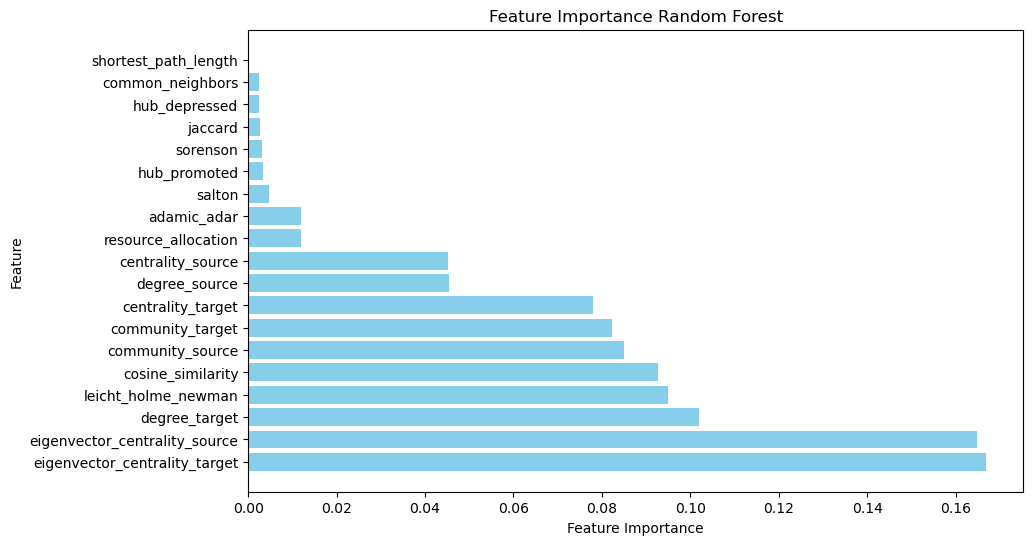

In [33]:
importance_dict = dict(zip(X_train.columns, rf.feature_importances_))

# Sort feature importances
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

feature_importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Random Forest')
plt.show()

In [84]:
selected_columns = ['degree_source', 'degree_target', 'community_source', 'community_target',\
                 'hub_promoted', 'leicht_holme_newman', 'eigenvector_centrality_source','eigenvector_centrality_target', 'cosine_similarity']

X_train = train_set_final[selected_columns]

In [85]:
x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [86]:
rf = RandomForestClassifier(random_state= 42)
rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")

Training Accuracy Random Forest: 1.0
Validation Accuracy Random Forest: 0.7133333333333334


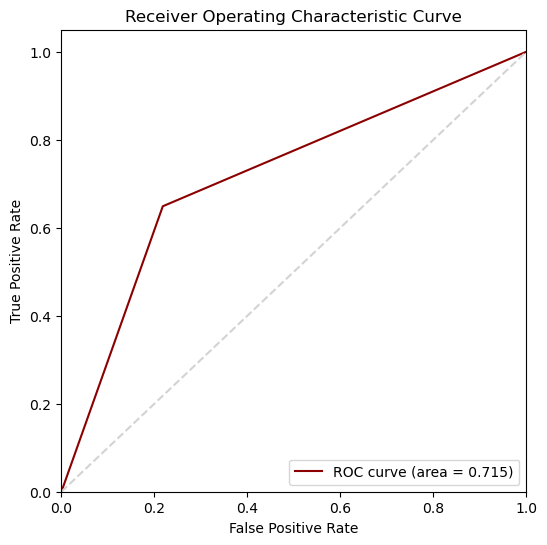

In [87]:
plot_roc_curve(y_val, y_pred)


In [ ]:
param_grid = {
    'max_depth': [None, 20, 30, 35, 40],  
    'n_estimators': [100, 200, 300]    
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, scoring='accuracy')

# Perform grid search on training data
grid_search.fit(x_train_val, y_train_val)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred_train = best_rf.predict(x_train_val)
y_pred_val = best_rf.predict(x_val)

# Compute accuracy
train_accuracy = accuracy_score(y_train_val, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)

print("Best Parameters:", best_params)
print(f"Training Accuracy Random Forest: {train_accuracy}")
print(f"Validation Accuracy Random Forest: {val_accuracy}")

Best Parameters: {'max_depth': 35, 'n_estimators': 100}
Training Accuracy Random Forest: 0.8423671395299598
Validation Accuracy Random Forest: 0.7276190476190476


In [175]:
rf = RandomForestClassifier(random_state= 42, max_depth = 14, n_estimators= 400, min_samples_split=3)

rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")



Training Accuracy Random Forest: 0.8310395934787211
Validation Accuracy Random Forest: 0.7352380952380952


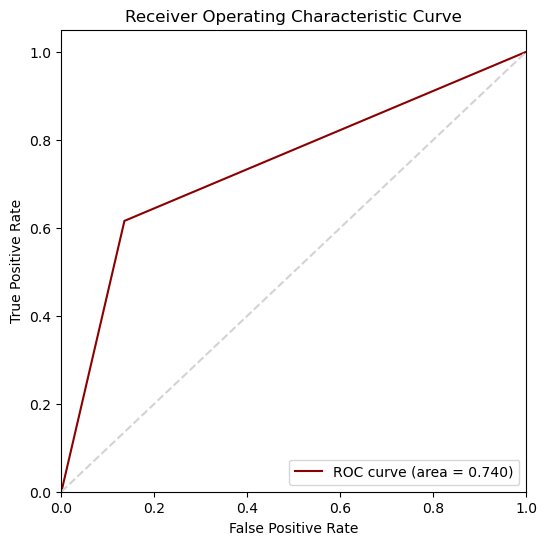

In [166]:
plot_roc_curve(y_val, y_pred)


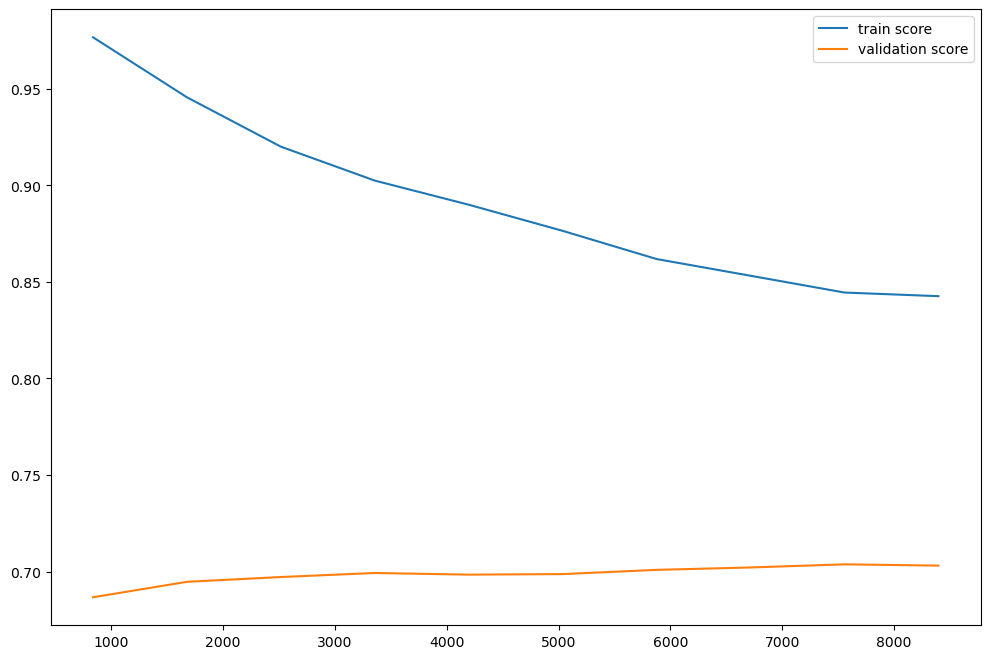

In [176]:
evaluation(rf)

# CATBOOST

In [302]:
selected_columns = ['degree_source', 'centrality_source', 'degree_target', 'centrality_target', 'community_source', 'community_target',\
                     'jaccard', 'salton', 'sorenson', 'hub_promoted', 'hub_depressed', 'leicht_holme_newman', 'adamic_adar', \
                        'resource_allocation', 'common_neighbors', 'shortest_path_length', 'eigenvector_centrality_source',\
                                'eigenvector_centrality_target', 'cosine_similarity']

X_train = train_set_final[selected_columns]
y_train = train_set_final['label']

In [303]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(random_state=42, silent=True)
cv_scores = cross_val_score(catboost, X_train, y_train, cv=5, scoring='accuracy')
print("Mean Accuracy:", cv_scores.mean())





Mean Accuracy: 0.7023617595680482


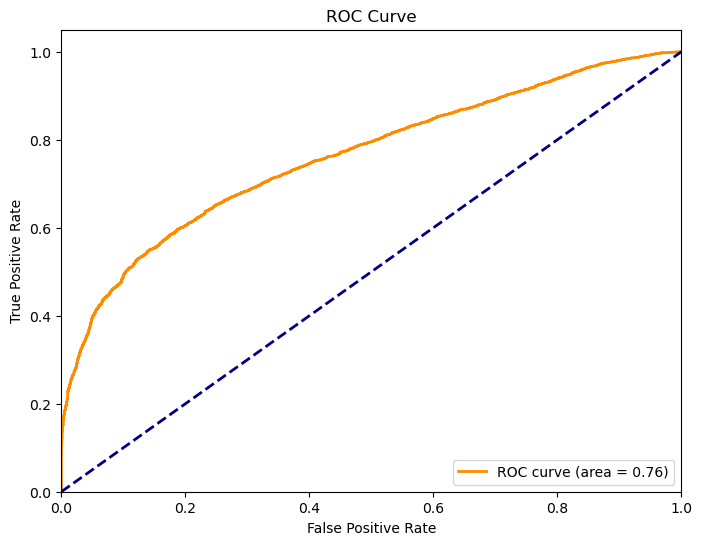

In [305]:
y_probas = cross_val_predict(catboost, X_train, y_train, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Learning rate set to 0.009558
0:	learn: 0.6903054	total: 1.02ms	remaining: 1.02s
1:	learn: 0.6879311	total: 2.06ms	remaining: 1.03s
2:	learn: 0.6848121	total: 3ms	remaining: 995ms
3:	learn: 0.6821522	total: 3.92ms	remaining: 977ms
4:	learn: 0.6798793	total: 4.83ms	remaining: 961ms
5:	learn: 0.6772254	total: 5.62ms	remaining: 931ms
6:	learn: 0.6749723	total: 7.27ms	remaining: 1.03s
7:	learn: 0.6727738	total: 9.24ms	remaining: 1.15s
8:	learn: 0.6703758	total: 10.3ms	remaining: 1.13s
9:	learn: 0.6683330	total: 11.1ms	remaining: 1.1s
10:	learn: 0.6660257	total: 12.1ms	remaining: 1.08s
11:	learn: 0.6636538	total: 13.1ms	remaining: 1.08s
12:	learn: 0.6614930	total: 14ms	remaining: 1.06s
13:	learn: 0.6595611	total: 15.4ms	remaining: 1.09s
14:	learn: 0.6579272	total: 16.3ms	remaining: 1.07s
15:	learn: 0.6562027	total: 17.3ms	remaining: 1.07s
16:	learn: 0.6540262	total: 18.1ms	remaining: 1.05s
17:	learn: 0.6522483	total: 18.9ms	remaining: 1.03s
18:	learn: 0.6501617	total: 19.7ms	remaining: 1.02

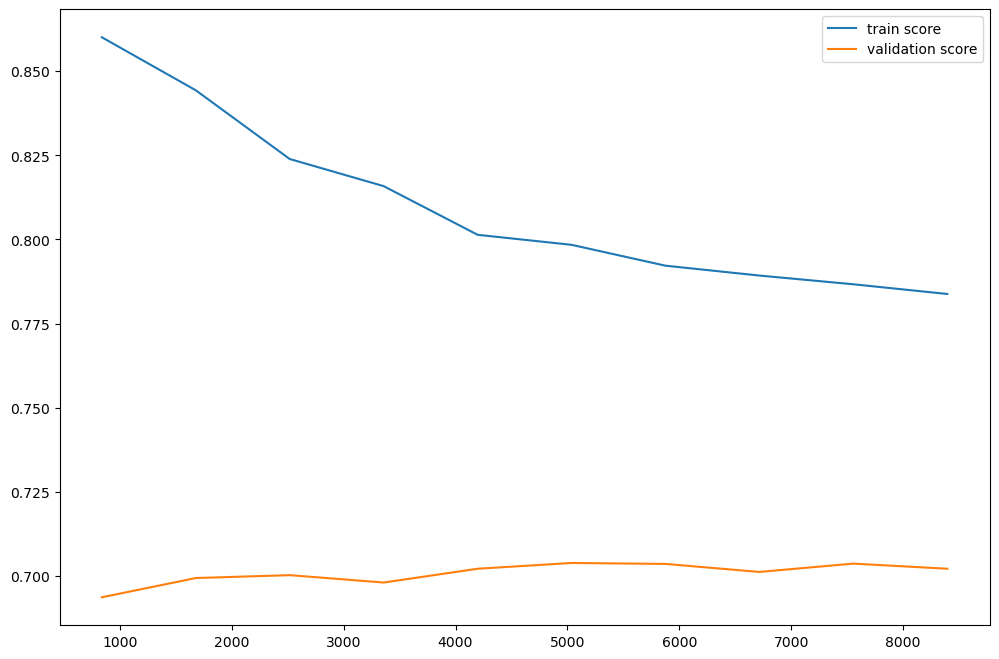

In [203]:
evaluation(catboost)

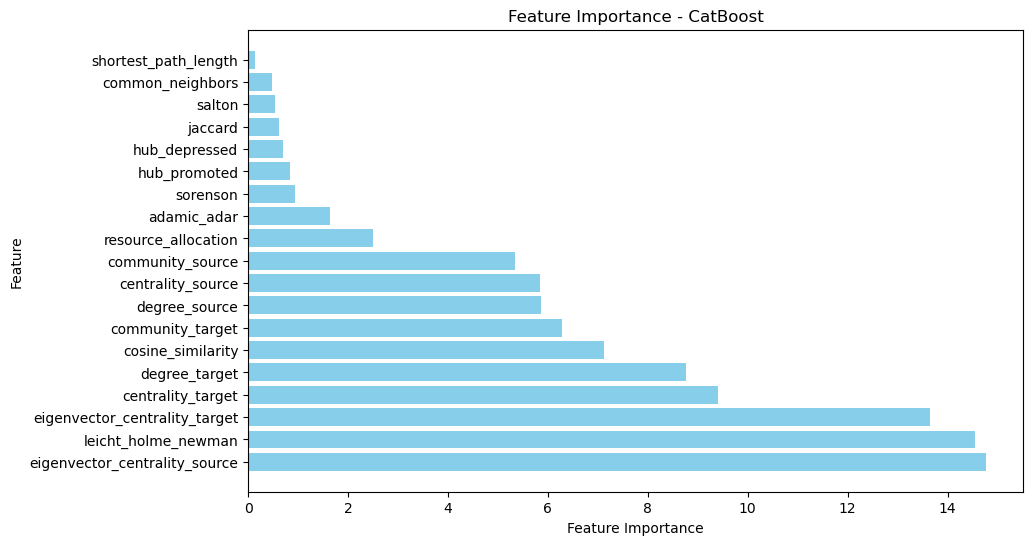

In [308]:
catboost.fit(X_train, y_train)
feature_importances = catboost.feature_importances_

feature_names = X_train.columns

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, color='skyblue')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.show()

In [329]:
selected_columns = ['degree_source', 'centrality_source', 'degree_target', 'centrality_target', 'community_source', 'community_target',\
                      'sorenson', 'leicht_holme_newman', 'adamic_adar', \
                        'resource_allocation', 'eigenvector_centrality_source',\
                                'eigenvector_centrality_target', 'cosine_similarity']

X_train = train_set_final[selected_columns]
y_train = train_set_final['label']

In [330]:
cv_scores = cross_val_score(catboost, X_train, y_train, cv=5, scoring='accuracy')
print("Mean Accuracy:", cv_scores.mean())

#70.4, -3 features

Mean Accuracy: 0.7041722362122552


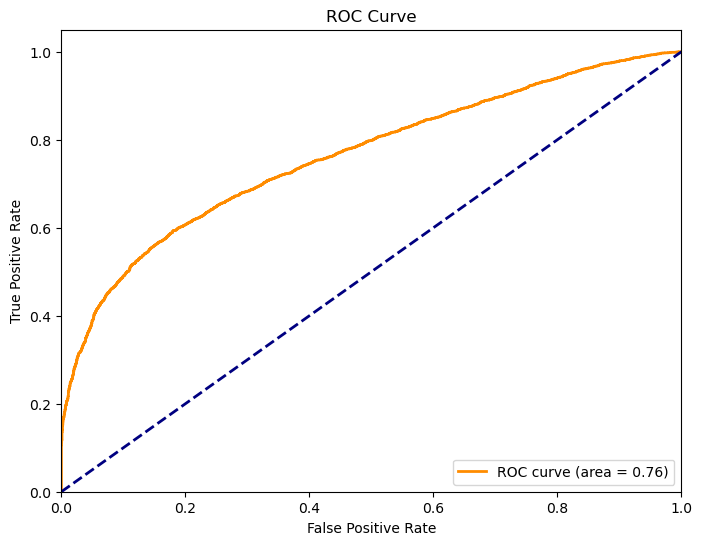

In [331]:
y_probas = cross_val_predict(catboost, X_train, y_train, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [372]:
from scipy.stats import randint

# Define the parameter distributions for the randomized search
param_dist = {
    'n_estimators': [50, 70, 100, 150, 200, 300],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the CatBoostClassifier
catboost = CatBoostClassifier(random_state=42, silent=True)

random_search = RandomizedSearchCV(catboost, param_distributions=param_dist, n_iter=90, cv=5, 
                                   scoring='accuracy', random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)  # Assuming you have X_train and y_train

print("Best Parameters:", random_search.best_params_)

val_accuracy = random_search.best_estimator_.score(X_train, y_train) 
print("Validation Accuracy after Hyperparameter Tuning:", val_accuracy)



Best Parameters: {'subsample': 0.9, 'n_estimators': 70, 'max_depth': 3}
Validation Accuracy after Hyperparameter Tuning: 0.7188452743902439


In [373]:
catboost = CatBoostClassifier(random_state=42, n_estimators = 70, max_depth = 3, subsample = 0.9, silent=True)

cv_scores = cross_val_score(catboost, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)

print("Mean Accuracy:", cv_scores.mean())



Cross-Validation Scores: [0.72190476 0.69080515 0.70033349 0.7279657  0.70557408]
Mean Accuracy: 0.7093166360398376


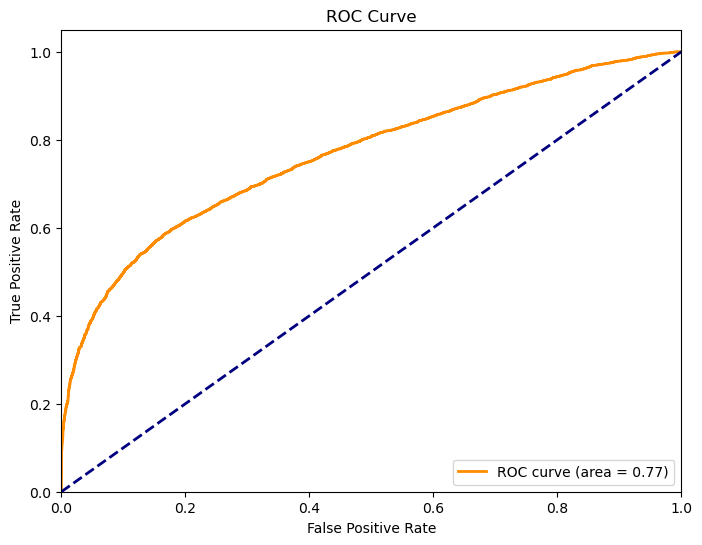

In [374]:
y_probas = cross_val_predict(catboost, X_train, y_train, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

SUBMISSIONS

In [366]:
test_set_final['cosine_similarity'] = train_set_final.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)
selected_columns = ['degree_source', 'centrality_source', 'degree_target', 'centrality_target', 'community_source', 'community_target',\
                      'sorenson', 'leicht_holme_newman', 'adamic_adar', \
                        'resource_allocation', 'eigenvector_centrality_source',\
                                'eigenvector_centrality_target', 'cosine_similarity']

X_test = test_set_final[selected_columns]

In [371]:
test_preds_values = catboost.predict(X_test)
test_preds_values = zip(np.array(range(len(X_test))), test_preds_values)

with open("../submission/Cat_Boost/cat_boost_preds.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()

# RANDOM FOREST VICTOR

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def edge_prediction_rf(train_set, test_col, plot_roc=True):
    # Splitting the dataset into training and testing
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[test_col].values
    test_features = test_samples[test_col].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    # --- Build the model and train it ---
    clf = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=4,  # Maximum depth of the trees. 'None' means no limit.
        min_samples_split=2,  # Minimum number of samples required to split an internal node
        min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
        max_features='auto',  # Number of features to consider when looking for the best split
        bootstrap=True,  # Whether bootstrap samples are used when building trees
        random_state=42  # Controls both the randomness of the bootstrapping and the features selected for splitting.
    )
    clf.fit(train_features, train_labels)
    
    feature_importances = clf.feature_importances_
    important_features = [test_col[i] for i in range(len(test_col)) if feature_importances[i] > 0.01]
    print("Important features:", important_features)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the ROC Curve from prediction scores ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc, test_accuracy
    
    # Plotting the ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf


In [ ]:
test_col = ['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']
roc_auc, test_accuracy, clf_rf = edge_prediction_rf(train_set, test_col)

print(test_accuracy)

In [ ]:
test_features = test_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
test_preds_values = clf_rf.predict(test_features)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

In [ ]:
with open("../submission/Random_Forest/rf_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()